In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 84% 125M/149M [00:00<00:00, 1.29GB/s]
100% 149M/149M [00:00<00:00, 1.18GB/s]


In [5]:
import zipfile
zipfileref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zipfileref.extractall()
zipfileref.close()

In [10]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [11]:
test_dir = '/content/Testing'
train_dir = '/content/Training'

In [12]:
import os
train_path = []
train_label = []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_path.append(os.path.join(train_dir,label,image))
    train_label.append(label)

train_path,train_label = shuffle(train_path,train_label)


In [13]:
test_path = []
test_label = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_path.append(os.path.join(test_dir,label,image))
    test_label.append(label)

test_path,test_label = shuffle(test_path,test_label)

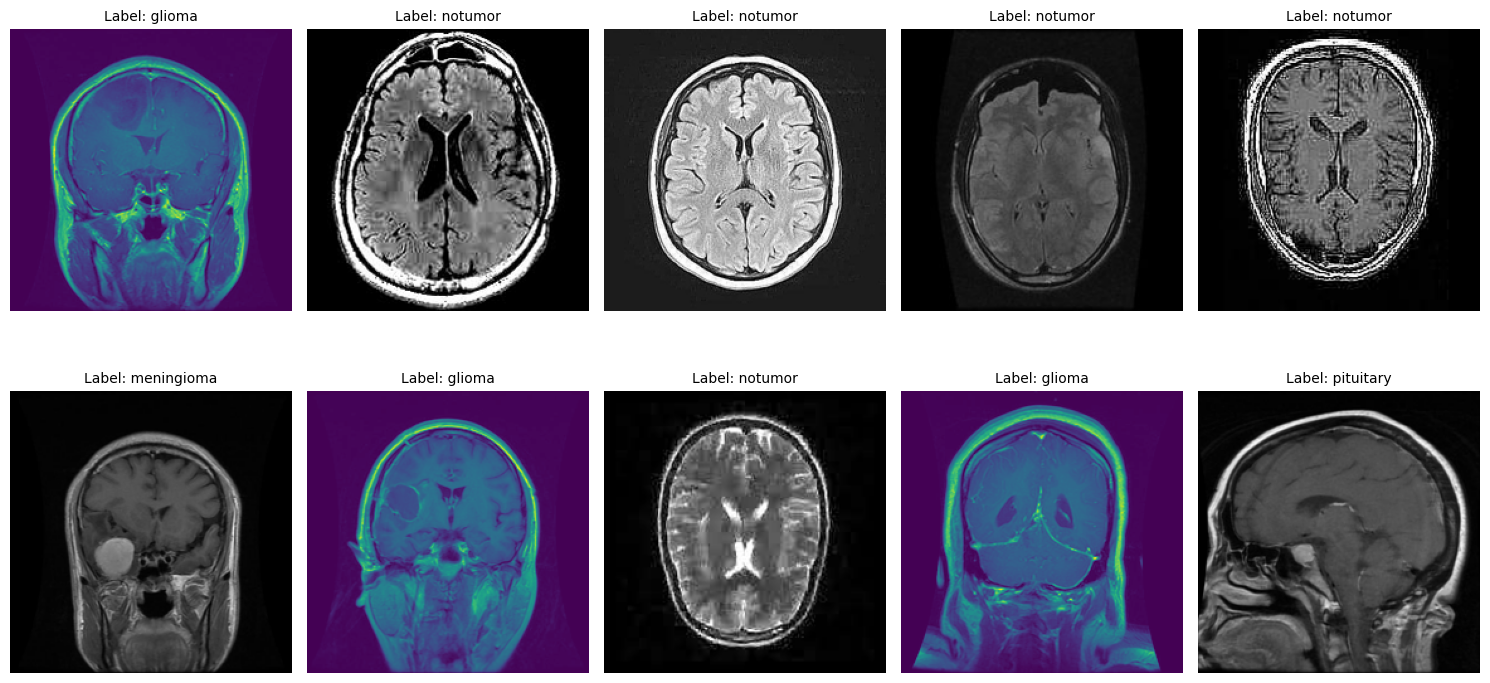

In [17]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_path)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_path[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_label[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [20]:
from PIL import Image
#IMage augmentation
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image) / 255.0
  return image

In [21]:
# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [22]:
IMAGE_SIZE=128
base_model = VGG16(weights='imagenet',include_top= False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [23]:
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [27]:
steps = int(len(train_path) / 20)
history = model.fit(datagen(train_path, train_label, batch_size=20, epochs=5),
                    epochs=5, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.9373
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.1372 - sparse_categorical_accuracy: 0.9490
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.9668
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.0510 - sparse_categorical_accuracy: 0.9816
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.0576 - sparse_categorical_accuracy: 0.9785


In [62]:
from tensorflow.keras.preprocessing.image import img_to_array
class_labels = ['notumor','pituitary', 'glioma', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


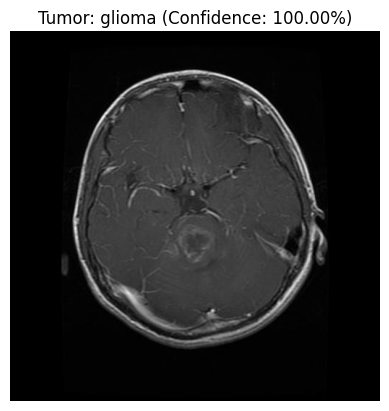

In [72]:
# Example usage
image_path = '/content/Testing/glioma/Te-glTr_0007.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

Confusion Matrix:
[[405   0   0   0]
 [  4 288   3   5]
 [  8   0 290   2]
 [ 15   0  32 259]]


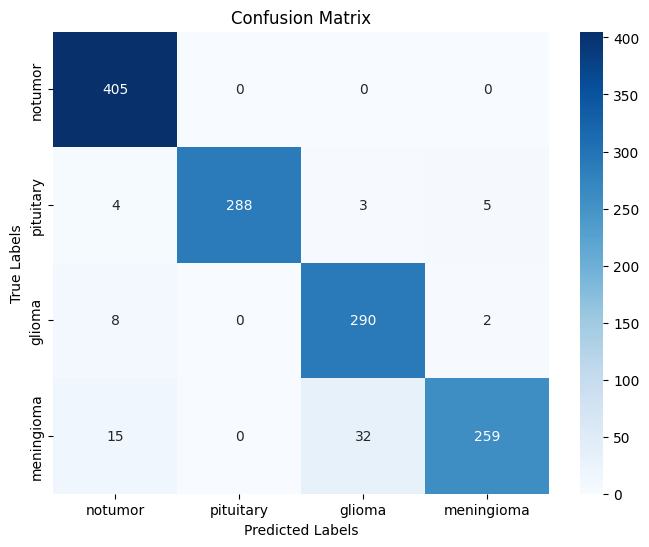

In [41]:
# 3. Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_path)  # Load and augment test images
test_labels_encoded = encode_label(test_label)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       405
           1       1.00      0.96      0.98       300
           2       0.89      0.97      0.93       300
           3       0.97      0.85      0.91       306

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.95      1311
weighted avg       0.95      0.95      0.95      1311

